#INTRODUCCIÓN

¿Es posible desarrollar un detector de tendencias sólo con un indicador y clusterización?

Se va a comprobar si es posible con el Williams %R, que no es más que una normalización del precio.

La hipótesis es que si el indicador tiene la mínima capacidad predictiva, con la generación de 2 clústers obtendremos un clúster que se identifica con las tendencias alcistas y otro con las tendencias bajistas.

Para comprobarlo se realizarán los siguientes pasos:

1) cálculo del Williams %R para un rango de parámetros a modo de variables

2) generación de 2 clústers con K-Means en el periodo de entrenamiento

3) comprobación en forward

Se utilizarán los siguientes periodos:

- train: 01/01/2010 -01/01/2020
- forward: 01/01/2020 - 01/01/2023

#ENTORNO

##DATOS

El activo utilizado en este código será el EURUSD en diario disponible en los siguientes enlaces:

- descarga: https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ

- visualización: https://drive.google.com/file/d/1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ/view?usp=sharing

##LIBRERÍAS

In [1]:
#INSTALACIÓN DE LIBRERÍA PARA CALCULAR INDICADORES TÉCNICOS
!pip install pandas_ta
!pip install yfinance
!pip install wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=cce2b3a3e680d2553f6d57d865a1f5d2bc00abd7c01c198c10b1b37d131cb316
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 1.2 MB/s eta 0:00:00


In [2]:
#IMPORTACIÓN DE LIBRERÍAS
import pandas_ta as ta
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import date
from scipy.stats import ks_2samp
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

##FUNCIONES

In [3]:
#FUNCIÓN PARA OBTENER LOS DATOS

import pandas as pd
import io

def get_data(data):
    """
    Lee los datos desde una cadena de texto CSV y devuelve un DataFrame.

    Parámetros:
    data (str): Cadena de texto que representa los datos CSV.

    Retorna:
    pandas.DataFrame: Un DataFrame que contiene los datos CSV.
    """

    # Convertir los datos en un objeto de archivo de texto
    data_file = io.StringIO(data)

    # Leer los datos desde el archivo CSV
    data_df = pd.read_csv(data_file)

    return data_df


In [3]:
#FUNCIÓN PARA CALCULAR WILLIAMS

def calculate_williams(data):
  """
  Calcula Williams %R para un rango de parámetros para los datos de precios de un activo específico.

  Args:
    data (pandas.DataFrame): Datos históricos del activo.

  Returns:
    pandas.DataFrame: Un DataFrame que contiene los indicadores calculados.
  """

  #Renombrar las columnas
  data.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
  #Establecer la fecha como índice
  data = data.set_index("Date")
  #Eliminar columnas innecesarias
  data = data.drop(["Time", "Volume"], axis=1)

  #Extraer columnas necesarias para el cálculo de indicadores
  close = data["Close"]
  high = data["High"]
  low = data["Low"]

  #Crear de listas para guardar el nombre de los indicadores y los valores
  indicators = []
  columns = []

  #Establecer rango de valores usados como parámetro para el cálculo de los indicadores
  periods = list(range(5,100))

  #WILLR - Williams' %R
  for n in periods:
    name = "WILLR" + str(n)
    indicators.append(ta.willr(high, low, close, n))
    columns.append(name)

  #Crear dataframe con todos los indicadores calculados
  df = pd.concat(indicators, axis=1)
  df.columns = columns
  df.index = data.index

  #Calcular el retorno a un día vista
  df["Open"] = data["Open"]
  df["Close"] = data["Close"]
  df["Return"] = df["Open"].pct_change().shift(-1)
  df = df.drop("Open", axis=1)

  #Eliminar las filas con valores faltantes
  #df = df.dropna()

  return df

In [4]:
#FUNCIÓN PARA CALCULAR WILLIAMS de yaju

def calculate_williams_ya(data):
  """
  Calcula Williams %R para un rango de parámetros para los datos de precios de un activo específico.

  Args:
    data (pandas.DataFrame): Datos históricos del activo.

  Returns:
    pandas.DataFrame: Un DataFrame que contiene los indicadores calculados.
  """
#Open         High          Low        Close    Adj Close  \
  #Renombrar las columnas
  #data.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
  print("columnas")
  data.columns = ["Open", "High", "Low", "Close", "AjClose", "Volume"]
  print("columnas arregladas")

  #Establecer la fecha como índice
  #data = data.set_index("Date")
  #Eliminar columnas innecesarias
  print("vola vol")
  data = data.drop(["Volume"], axis=1)
  print("vola clos")
  data = data.drop(["AjClose"], axis=1)
  print("vola volo")
  #Extraer columnas necesarias para el cálculo de indicadores
  close = data["Close"]
  high = data["High"]
  low = data["Low"]

  #Crear de listas para guardar el nombre de los indicadores y los valores
  indicators = []
  columns = []

  #Establecer rango de valores usados como parámetro para el cálculo de los indicadores
  periods = list(range(5,100))

  #WILLR - Williams' %R
  for n in periods:
    name = "WILLR" + str(n)
    indicators.append(ta.willr(high, low, close, n))
    columns.append(name)

  #Crear dataframe con todos los indicadores calculados
  df = pd.concat(indicators, axis=1)
  df.columns = columns
  df.index = data.index

  #Calcular el retorno a un día vista
  df["Open"] = data["Open"]
  df["Close"] = data["Close"]
  df["Return"] = df["Open"].pct_change().shift(-1)
  df = df.drop("Open", axis=1)

  #Eliminar las filas con valores faltantes
  #df = df.dropna()

  return df

In [5]:
def split(data, numero_barras):
    """
    Divide los datos en conjuntos de entrenamiento y forward, dejando las últimas dos filas en forward.

    Args:
      data (pandas.DataFrame): DataFrame que contiene los datos a dividir.

    Returns:
      tuple: Una tupla que contiene los siguientes conjuntos de datos:
        - train (pandas.DataFrame): Conjunto de entrenamiento.
        - forward (pandas.DataFrame): Conjunto forward.
    """
    # Dejar las últimas dos filas en forward
    forward = data.iloc[-numero_barras:, :]

    # Resto de las filas en train
    train = data.iloc[:-numero_barras, :]

    return train, forward


#DATASET

In [1]:
#GENERACIÓN DEL DATASET

#Obtener datos
#data = get_data("https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ")

#Calcular indicadores
#data = calculate_williams(data)

#Realizar particiones
#train, forward = split(data)

#forward.head(5)

In [30]:
symbol = "PAMP.BA"

start_date="2010-01-01"

end_date="2024-03-31"

data =yf.download(symbol, start=start_date, end=end_date)
# Convertir los datos en un DataFrame de pandas
data_df = pd.DataFrame(data)

#data_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

#data_df.reindex(columns=['fecha', 'especie', 'apertura', 'maximo', 'minimo', 'cierre', 'volumen', 'timestamp'])

print("                mis datos")
print(data_df)
print("findatos")
#msft = yf.Ticker("COME.BA")




# get historical market data
#hist = msft.history(period="1mo")



[*********************100%%**********************]  1 of 1 completed

                mis datos
               Open         High          Low        Close    Adj Close  \
Date                                                                      
2010-01-04     1.81     1.830000     1.800000     1.810000     1.799476   
2010-01-05     1.81     1.830000     1.770000     1.790000     1.779592   
2010-01-06     1.75     1.770000     1.710000     1.720000     1.709999   
2010-01-07     1.72     1.750000     1.680000     1.740000     1.729883   
2010-01-08     1.72     1.720000     1.680000     1.680000     1.670232   
...             ...          ...          ...          ...          ...   
2024-03-07  1700.00  1717.300049  1610.000000  1622.300049  1622.300049   
2024-03-08  1638.00  1675.000000  1607.550049  1668.500000  1668.500000   
2024-03-11  1700.00  1700.000000  1584.650024  1604.150024  1604.150024   
2024-03-12  1609.00  1739.949951  1609.000000  1700.000000  1700.000000   
2024-03-13  1740.00  1769.099976  1671.650024  1693.000000  1693.000000   

In [31]:
#Calcular indicadores
data = calculate_williams_ya(data_df)
print(data)
print("tatime")
data_trimmed = data.iloc[:-2]
print(data_trimmed)

#Realizar particiones
train, forward = split(data, 100)

train= train.dropna()
train.head(3)

print("fowar")
forward

columnas
columnas arregladas
vola vol
vola clos
vola volo
                WILLR5     WILLR6     WILLR7     WILLR8     WILLR9    WILLR10  \
Date                                                                            
2010-01-04         NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-05         NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-06         NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-07         NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-08 -100.000000        NaN        NaN        NaN        NaN        NaN   
...                ...        ...        ...        ...        ...        ...   
2024-03-07  -96.780092 -96.780092 -96.780092 -96.780092 -97.331877 -97.331877   
2024-03-08  -84.146194 -84.146194 -84.146194 -84.146194 -84.146194 -86.848644   
2024-03-11  -91.953785 -95.212962 -95.212962 -95.212962 -95.212962 -95.212962   
2024-03-12  -34.959125 -52.403554 -71.682832 -71.68

,WILLR5,WILLR6,WILLR7,WILLR8,WILLR9,WILLR10,WILLR11,WILLR12,WILLR13,WILLR14,...,WILLR92,WILLR93,WILLR94,WILLR95,WILLR96,WILLR97,WILLR98,WILLR99,Close,Return
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-17,-6.902174,-6.902174,-6.600832,-5.777980,-5.512153,-5.512153,-5.327181,-5.327181,-5.327181,-5.327181,...,-3.125000,-3.112745,-3.035373,-2.965627,-2.965627,-2.965627,-2.965627,-2.965627,1744.250000,0.115625
2023-10-18,-28.000000,-23.880597,-23.880597,-22.857143,-20.053715,-19.145299,-19.145299,-18.512397,-18.512397,-18.512397,...,-10.926829,-10.926829,-10.884354,-10.616114,-10.374213,-10.374213,-10.374213,-10.374213,1673.000000,-0.078992
2023-10-19,-43.983165,-40.524994,-34.562895,-34.562895,-33.081628,-29.024168,-27.709398,-27.709398,-26.793384,-26.793384,...,-15.814632,-15.814632,-15.814632,-15.753156,-15.364927,-15.014818,-15.014818,-15.014818,1622.900024,0.024939
2023-10-20,-17.719345,-12.522051,-11.537506,-9.840090,-9.840090,-9.418372,-8.263209,-7.888893,-7.888893,-7.628103,...,-4.502441,-4.502441,-4.502441,-4.502441,-4.484939,-4.374410,-4.274734,-4.274734,1738.849976,-0.020772
2023-10-23,-91.036355,-91.036355,-67.928352,-62.587494,-53.379526,-53.379526,-51.091832,-44.825421,-42.794868,-42.794868,...,-24.424388,-24.424388,-24.424388,-24.424388,-24.424388,-24.329444,-23.729856,-23.189142,1534.650024,-0.042424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-07,-96.780092,-96.780092,-96.780092,-96.780092,-97.331877,-97.331877,-97.331877,-97.331877,-97.331877,-97.331877,...,-67.979658,-67.979658,-67.979658,-67.979658,-67.979658,-67.979658,-67.979658,-67.979658,1622.300049,-0.036471
2024-03-08,-84.146194,-84.146194,-84.146194,-84.146194,-84.146194,-86.848644,-86.848644,-86.848644,-86.848644,-86.848644,...,-64.847458,-64.847458,-64.847458,-64.847458,-64.847458,-64.847458,-64.847458,-64.847458,1668.500000,0.037851
2024-03-11,-91.953785,-95.212962,-95.212962,-95.212962,-95.212962,-95.212962,-95.990542,-95.990542,-95.990542,-95.990542,...,-69.210168,-69.210168,-69.210168,-69.210168,-69.210168,-69.210168,-69.210168,-69.210168,1604.150024,-0.053529


#CLUSTERING

In [32]:
#GENERACIÓN DE CLÚSTERS

#Preparar datos de entrenamiento
#print(X_train.head(5))

X_train = train.iloc[:,:-2]

#print(X_train.head(5))

#Preparar datos forward
X_forward = forward.iloc[:,:-2]

#Aplicar K-Means
kmeans = KMeans(n_clusters=2).fit(X_train)
predictions = kmeans.predict(X_forward)

#Generar predicciones en forward
df_forward = pd.DataFrame(forward["Return"])
df_forward["Pred"] = predictions
df_forward["Close"] = forward["Close"]
df_forward.head(50)

,Return,Pred,Close
Date,,,
2023-10-17,0.115625,0,1744.250000
2023-10-18,-0.078992,0,1673.000000
2023-10-19,0.024939,0,1622.900024
2023-10-20,-0.020772,0,1738.849976
2023-10-23,-0.042424,0,1534.650024
2023-10-24,-0.078797,1,1455.500000
2023-10-25,0.029200,0,1483.400024
2023-10-26,-0.045394,1,1443.000000
2023-10-27,-0.032902,1,1354.349976


In [33]:
#COMPROBACIÓN DE CLÚSTERS

#Calcular retornos medios del clúster con la etiqueta 0
ave_zero = np.mean(df_forward[df_forward["Pred"]==0]["Return"])
print("Retorno medio de la etiqueta 0:", round(ave_zero, 4))

#Calcular retornos medios del clúster con la etiqueta 1
ave_one = np.mean(df_forward[df_forward["Pred"]==1]["Return"])
print("Retorno medio de la etiqueta 1:", round(ave_one, 4))

Retorno medio de la etiqueta 0: 0.0083
Retorno medio de la etiqueta 1: -0.007


In [34]:
#RENOMBRADO DE LAS ETIQUETAS OTORGADAS POR K-MEANS EN 1 O -1

#Renombrar etiquetas
if ave_zero > ave_one:
  df_forward["Pred"] = np.where(df_forward["Pred"]==0, 1, -1)
else:
  df_forward["Pred"] = np.where(df_forward["Pred"]==0, -1, 1)

In [35]:
#FORMATO DE FECHAS
dates = pd.to_datetime(df_forward.index)
df_forward.set_index(dates, inplace=True)

print(df_forward)

cabeza= df_forward.head(400)
cola = df_forward.tail(300)

              Return  Pred        Close
Date                                   
2023-10-17  0.115625     1  1744.250000
2023-10-18 -0.078992     1  1673.000000
2023-10-19  0.024939     1  1622.900024
2023-10-20 -0.020772     1  1738.849976
2023-10-23 -0.042424     1  1534.650024
...              ...   ...          ...
2024-03-07 -0.036471    -1  1622.300049
2024-03-08  0.037851    -1  1668.500000
2024-03-11 -0.053529    -1  1604.150024
2024-03-12  0.081417    -1  1700.000000
2024-03-13       NaN    -1  1693.000000

[100 rows x 3 columns]


#COMPROBACIONES

##GRÁFICO

Graficando la evolución del precio pintando cada punto según el clúster podremos comprobar si se distinguen tendencias alcistas y bajistas.

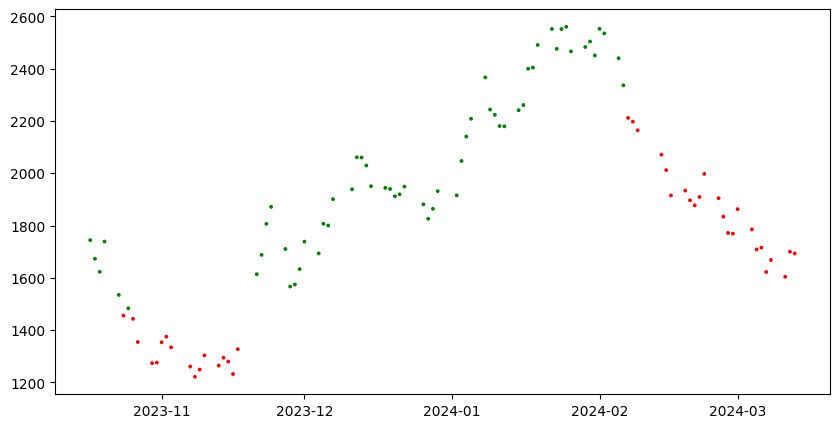

In [36]:
#GRÁFICO CON LAS PREDICCIONES

#Crear una lista de colores según predicción
colors = ['green' if c == 1 else 'red' for c in cola["Pred"]]

#Crear el gráfico
plt.figure(figsize=(10, 5))
plt.scatter(cola.index, cola["Close"], c=colors, s=3)
plt.show()

##HISTOGRAMAS

Superponiendo el histograma de los retornos correspondientes a cada clúster podremos comprobar las diferencias entre cada clúster.

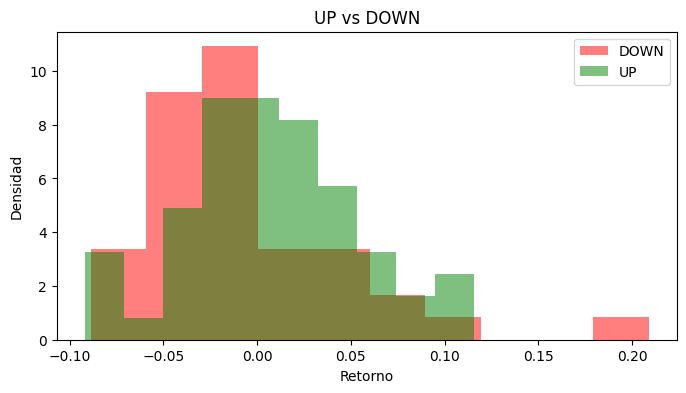

In [37]:
#HISTOGRAMAS SUPERPUESTOS DE LOS RETORNOS DE LOS CLÚSTERS

#Generar histogramas
plt.figure(figsize=(8, 4))
plt.hist(df_forward[df_forward["Pred"]==-1]["Return"], density=True, alpha=0.5, color="red", label="DOWN")
plt.hist(df_forward[df_forward["Pred"]==1]["Return"], density=True, alpha=0.5, color="green", label="UP")
plt.xlabel("Retorno")
plt.ylabel("Densidad")
plt.title("UP vs DOWN")
plt.legend()
plt.show()

##TEST ESTADÍSTICO

Realizando el test de Kolmogorov-Smirnov podremos confirmar si los clústers son significativamente diferentes: el estadístico nos mostrará la magnitud de la diferencia y el p_value la fiabilidad del test.

In [38]:
#TEST DE KOLMOGOROV-SMIRNOV

#Aplicar test de Kolmogorov-Smirnov
statistic, p_value = ks_2samp(df_forward.loc[df_forward["Pred"] == 1, "Return"],
                              df_forward.loc[df_forward["Pred"] == -1, "Return"])

print("Estadístico:", statistic)
print("P_value:", p_value)

Estadístico: 0.2273666804464655
P_value: 0.13590162994504607


#CONCLUSIÓN

:Se ha podido comprobar visual y estadísticamente que un único indicador es suficiente para distinguir tendencias con clusterización.


In [60]:
import pandas as pd

# Lista de activos
activos = ['GGAL', 'META', 'COME', 'SEMIO']

# Ejemplo de datos
data = pd.DataFrame({
    'Date': ['2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-23'],
    'Pred': [17, 180, 19, 20, 23],
    'Close': [1744.250000, 1673.000000, 1622.900024, 1738.849976, 1534.650024]
})

# Convertir la columna 'Date' a datetime
data['Date'] = pd.to_datetime(data['Date'])

# Crear un DataFrame vacío para almacenar los datos pivoteados
datos_pivotados = pd.DataFrame(index=data['Date'])

# Iterar sobre la lista de activos
for activo in activos:
    print(activo)
    print(data['Pred'])
    # Agregar los datos de predicción del activo al DataFrame pivoteado
    datos_pivotados[activo] = data['Pred']

print(datos_pivotados)
# Transponer el DataFrame para que los activos estén en filas y las fechas en columnas
datos_pivotados = datos_pivotados.transpose()

print(data)
# Imprimir el DataFrame pivoteado
print(datos_pivotados)




GGAL
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
META
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
COME
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
SEMIO
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
            GGAL  META  COME  SEMIO
Date                               
2023-10-17   NaN   NaN   NaN    NaN
2023-10-18   NaN   NaN   NaN    NaN
2023-10-19   NaN   NaN   NaN    NaN
2023-10-20   NaN   NaN   NaN    NaN
2023-10-23   NaN   NaN   NaN    NaN
        Date  Pred        Close
0 2023-10-17    17  1744.250000
1 2023-10-18   180  1673.000000
2 2023-10-19    19  1622.900024
3 2023-10-20    20  1738.849976
4 2023-10-23    23  1534.650024
Date   2023-10-17  2023-10-18  2023-10-19  2023-10-20  2023-10-23
GGAL          NaN         NaN         NaN         NaN         NaN
META          NaN         NaN         NaN         NaN         NaN
COME          NaN         NaN         NaN         NaN    